In [1]:
import copy
import json
import math
import os
import urllib.request
from urllib.error import HTTPError

import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data

%matplotlib inline
from IPython.display import set_matplotlib_formats
from matplotlib import cm
from torchvision import transforms
from torchvision.datasets import FashionMNIST
from tqdm.notebook import tqdm

set_matplotlib_formats("svg", "pdf")  # For export
sns.set()

G:\Temp\ipykernel_8656\1682095326.py:24: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats("svg", "pdf")  # For export


In [2]:
# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = os.environ.get("PATH_DATASETS", "data/")
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = os.environ.get("PATH_CHECKPOINT", "saved_models/InitOptim/")

# Seed everything
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

Global seed set to 42


Using device cuda:0


In [3]:
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial4/"
# Files to download
pretrained_files = [
    "FashionMNIST_SGD.config",
    "FashionMNIST_SGD_results.json",
    "FashionMNIST_SGD.tar",
    "FashionMNIST_SGDMom.config",
    "FashionMNIST_SGDMom_results.json",
    "FashionMNIST_SGDMom.tar",
    "FashionMNIST_Adam.config",
    "FashionMNIST_Adam_results.json",
    "FashionMNIST_Adam.tar",
]
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print(
                "Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n",
                e,
            )

### Preperation

In [4]:
# Transformations applied on each image => first make them a tensor, then normalize them with mean 0 and std 1
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.2861,), (0.3530,))])

# Loading the training dataset. We need to split it into a training and validation part
train_dataset = FashionMNIST(root=DATASET_PATH, train=True, transform=transform, download=True)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

# Loading the test set
test_set = FashionMNIST(root=DATASET_PATH, train=False, transform=transform, download=True)

### DataLoaders

In [5]:
train_loader = data.DataLoader(train_set, batch_size=1024, shuffle=True, drop_last=False)
val_loader = data.DataLoader(val_set, batch_size=1024, shuffle=False, drop_last=False)
test_loader = data.DataLoader(test_set, batch_size=1024, shuffle=False, drop_last=False)

In [6]:
print("Mean", (train_dataset.data.float() / 255.0).mean().item())
print("Std", (train_dataset.data.float() / 255.0).std().item())

Mean 0.28604060411453247
Std 0.3530242443084717


In [7]:
# Verify transformation
imgs, _ = next(iter(train_loader))

print(f"Mean: {imgs.mean().item():5.3f}")
print(f"Standard deviation: {imgs.std().item():5.3f}")
print(f"Maximum: {imgs.max().item():5.3f}")
print(f"Minimum: {imgs.min().item():5.3f}")

Mean: 0.020
Standard deviation: 1.011
Maximum: 2.022
Minimum: -0.810


In [8]:
# A Linear Neural Net
class BaseNetwork(nn.Module):
    def __init__(self, act_fn, input_size=784, num_classes=10, hidden_sizes=[512, 256, 256, 128]):
        """
        Args:
            act_fn: Object of the activation function that should be used as non-linearity in the network.
            input_size: Size of the input images in pixels
            num_classes: Number of classes we want to predict
            hidden_sizes: A list of integers specifying the hidden layer sizes in the NN
        """
        super().__init__()

        # Create the network based on the specified hidden sizes
        layers = []
        layer_sizes = [input_size] + hidden_sizes
        for layer_index in range(1, len(layer_sizes)):
            layers += [nn.Linear(layer_sizes[layer_index - 1], layer_sizes[layer_index]), act_fn]
        layers += [nn.Linear(layer_sizes[-1], num_classes)]
        # A module list registers a list of modules as submodules (e.g. for parameters)
        self.layers = nn.ModuleList(layers)

        self.config = {
            "act_fn": act_fn.__class__.__name__,
            "input_size": input_size,
            "num_classes": num_classes,
            "hidden_sizes": hidden_sizes,
        }

    def forward(self, x):
        x = x.view(x.size(0), -1)
        for layer in self.layers:
            x = layer(x)
        return x

For activation functions, we use `torch.nn` but we will be using `Identity` activation function. Although this activation function would significantly limit the network’s modeling capabilities, we will use it in the first steps of our discussion about initialization (for simplicity).

In [9]:
class Identity(nn.Module):
    def forward(self, x):
        return x


act_fn_by_name = {"tanh": nn.Tanh, "relu": nn.ReLU, "identity": Identity}

In [13]:
# Some Plotting Functions
##############################################################
def plot_dists(val_dict, color="C0", xlabel=None, stat="count", use_kde=True):
    columns = len(val_dict)
    fig, ax = plt.subplots(1, columns, figsize=(columns * 3, 2.5))
    fig_index = 0
    for key in sorted(val_dict.keys()):
        key_ax = ax[fig_index % columns]
        sns.histplot(
            val_dict[key],
            ax=key_ax,
            color=color,
            bins=50,
            stat=stat,
            kde=use_kde and ((val_dict[key].max() - val_dict[key].min()) > 1e-8),
        )  # Only plot kde if there is variance
        hidden_dim_str = (
            r"(%i $\to$ %i)" % (val_dict[key].shape[1], val_dict[key].shape[0]) if len(val_dict[key].shape) > 1 else ""
        )
        key_ax.set_title(f"{key} {hidden_dim_str}")
        if xlabel is not None:
            key_ax.set_xlabel(xlabel)
        fig_index += 1
    fig.subplots_adjust(wspace=0.4)
    return fig


##############################################################

def visualize_weight_distribution(model, color="C0"):
    weights = {}
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            continue
        key_name = f"Layer {name.split('.')[1]}"
        weights[key_name] = param.detach().view(-1).cpu().numpy()

    # Plotting
    fig = plot_dists(weights, color=color, xlabel="Weight vals")
    fig.suptitle("Weight distribution", fontsize=14, y=1.05)
    plt.show()
    plt.close()


##############################################################

def visualize_gradients(model, color="C0", print_variance=False):
    """
    Args:
        net: Object of class BaseNetwork
        color: Color in which we want to visualize the histogram (for easier separation of activation functions)
    """
    model.eval()
    small_loader = data.DataLoader(train_set, batch_size=1024, shuffle=False)
    imgs, labels = next(iter(small_loader))
    imgs, labels = imgs.to(device), labels.to(device)

    # Pass one batch through the network, and calculate the gradients for the weights
    model.zero_grad()
    preds = model(imgs)
    loss = F.cross_entropy(preds, labels)  # Same as nn.CrossEntropyLoss, but as a function instead of module
    loss.backward()
    # We limit our visualization to the weight parameters and exclude the bias to reduce the number of plots
    grads = {
        name: params.grad.view(-1).cpu().clone().numpy()
        for name, params in model.named_parameters()
        if "weight" in name
    }
    model.zero_grad()

    # Plotting
    fig = plot_dists(grads, color=color, xlabel="Grad magnitude")
    fig.suptitle("Gradient distribution", fontsize=14, y=1.05)
    plt.show()
    plt.close()

    if print_variance:
        for key in sorted(grads.keys()):
            print(f"{key} - Variance: {np.var(grads[key])}")


##############################################################

def visualize_activations(model, color="C0", print_variance=False):
    model.eval()
    small_loader = data.DataLoader(train_set, batch_size=1024, shuffle=False)
    imgs, labels = next(iter(small_loader))
    imgs, labels = imgs.to(device), labels.to(device)

    # Pass one batch through the network, and calculate the gradients for the weights
    feats = imgs.view(imgs.shape[0], -1)
    activations = {}
    with torch.no_grad():
        for layer_index, layer in enumerate(model.layers):
            feats = layer(feats)
            if isinstance(layer, nn.Linear):
                activations[f"Layer {layer_index}"] = feats.view(-1).detach().cpu().numpy()

    # Plotting
    fig = plot_dists(activations, color=color, stat="density", xlabel="Activation vals")
    fig.suptitle("Activation distribution", fontsize=14, y=1.05)
    plt.show()
    plt.close()

    if print_variance:
        for key in sorted(activations.keys()):
            print(f"{key} - Variance: {np.var(activations[key])}")

##############################################################

### Initialization

When initializing a neural net, `variance` of the input should be propagated through the model to the last layer, so that we have a similar `std` for the output vectors. If `variance` would vanish the deeper we go in our model, it becomes harder to `optimize` model as input to the next layer is basically a `constant` value.

If `variance` increases, it is likely to `explode` the deeper we design our model. The second property we look out for initialization techniques is `gradient` distribution with equal `variance` across layers. If the first layer receives much smaller gradients than the last layer, we will have difficulties in choosing an appropriate learning rate.

As a starting point for finding a good method, we will analyze different initialization based on our neural net with no activation function.

In [11]:
model = BaseNetwork(act_fn=Identity()).to(device)

#### Constant Initialization

In this, we initialize all weights with the same `constant` value. Setting all weights to `0` would not be good as the `propagated` gradient will be zero.

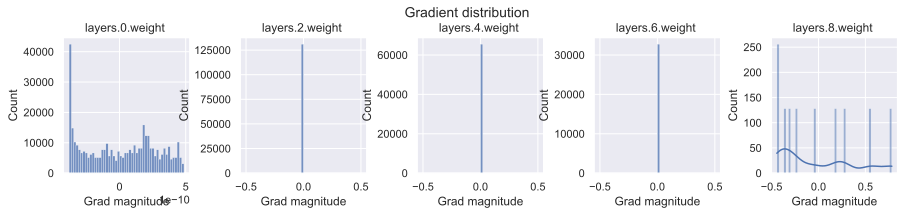

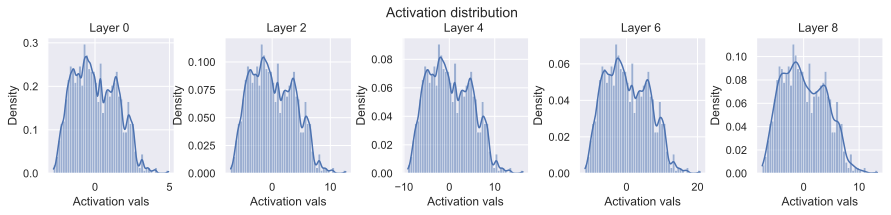

Layer 0 - Variance: 2.0582759380340576
Layer 2 - Variance: 13.489114761352539
Layer 4 - Variance: 22.100566864013672
Layer 6 - Variance: 36.20956802368164
Layer 8 - Variance: 14.831439018249512


In [14]:
def const_init(model, fill=0.0):
    for name, param in model.named_parameters():
        param.data.fill_(fill)


const_init(model, fill=0.005)
visualize_gradients(model)
visualize_activations(model, print_variance=True)

So, as we can see that only `first` and `last` layer have diverse gradient distributions while other layers have the same `gradient` for all weights. Having the same `gradient` for parameters that have been initialized with the same values means that we will always have the same value for those parameters.

This would make our layer `useless` and `reduce` the effective no. of parameters to `1`. Thus, we can't use `constant` initialization.

#### Constant Variance
As, `constant` initialization is not working, we will initialize the parameters by `randomly` sampling from a distribution. In this, we would choose a `variance` that is used for all layers in the network.

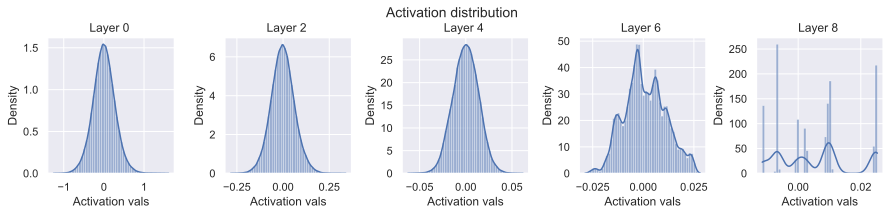

Layer 0 - Variance: 0.07582651078701019
Layer 2 - Variance: 0.003991635050624609
Layer 4 - Variance: 0.00019090263231191784
Layer 6 - Variance: 0.00010300602298229933
Layer 8 - Variance: 0.00014106817252468318


In [15]:
def var_init(model, std=0.01):
    for name, param in model.named_parameters():
        param.data.normal_(mean=0.0, std=std)


var_init(model, std=0.01)
visualize_activations(model, print_variance=True)

The `variance` of the activation becomes smaller and smaller across layers, and almost `vanishes` in the `last` layer. So, try it with a higher standard deviation.

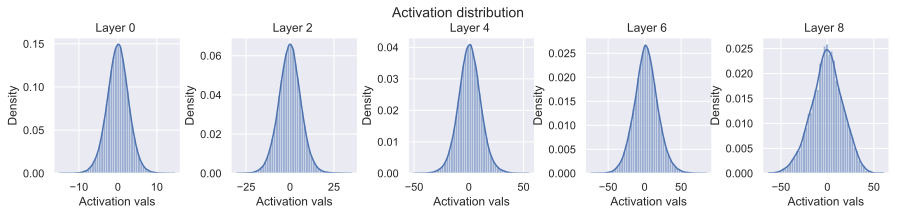

Layer 0 - Variance: 7.882627964019775
Layer 2 - Variance: 41.255001068115234
Layer 4 - Variance: 107.71039581298828
Layer 6 - Variance: 264.2112731933594
Layer 8 - Variance: 286.96563720703125


In [16]:
var_init(model, std=0.1)
visualize_activations(model, print_variance=True)

With a higher `std`, the activations are likely to `explode`. It would be hard to find the specific std values which gives a good activation function. 

##### How to find Appropriate initialization value
From above, it is clear that we need to sample the weights from a `distribution`. So, we will try to find an optimal initialization from the perspective of activation function. For this

1. The mean of the activations should be 0.
2. The variance of the activations should stay same across every layer.

<img src="assets\appropriate_initialization.jpg">
<img src="assets\appropriate_initialization_2.jpg">




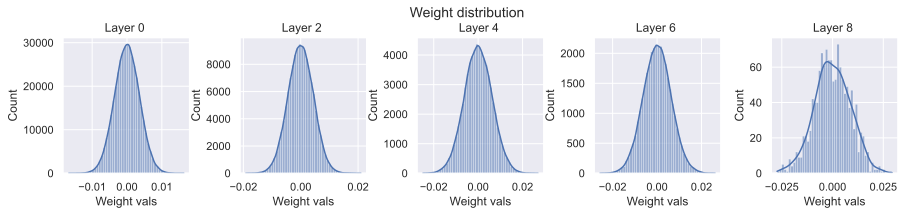

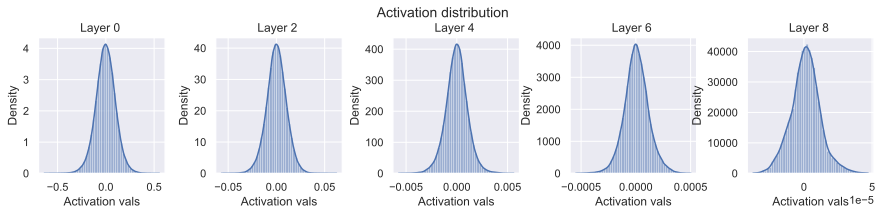

Layer 0 - Variance: 0.010486350394785404
Layer 2 - Variance: 0.00010592643229756504
Layer 4 - Variance: 1.1322540558467153e-06
Layer 6 - Variance: 1.2401805804529431e-08
Layer 8 - Variance: 1.1650122533346519e-10


In [17]:
def equal_var_init(model):
    for name, param in model.named_parameters():
        if name.endswith('.bias'):
            param.data.fill_(0)
        else:
            param.data.normal_(std=0.1 / math.sqrt(param.shape[1]))


equal_var_init(model)
visualize_weight_distribution(model)
visualize_activations(model, print_variance=True)

As expected, `variance` stays indeed constant across layers. Note that our initialization does not restrict us to a normal distribution, but allows any other distribution with a `mean` of `0` and `variance` of `1/d_x`. You often see that a uniform distribution is used for initialization. A small benifit of using a uniform instead of a normal distribution is that we can exclude the chance of initializing very `large` or `small` weights.

Besides the `variance` of the activations, another `variance` we would like to stabilize is the one of the `gradients`. This ensures a stable optimization for deep networks. It turns out that we can do the same calculation as above starting from <img src="https://pytorch-lightning.readthedocs.io/en/latest/_images/math/0e4c8ddcce0719b9eda570bdef39cf15296781e8.png"/>, and come up to conclusion that we should initialize our layers with `1/dy`, where dy is the number of output neurons. 

There is another proposed method known as `Xavier Initialization`.

<img src="https://pytorch-lightning.readthedocs.io/en/latest/_images/math/7962336a6de38100e7366606da9a0cb3300a3432.png"/>

If we use a uniform distribution, we would initialize the weights with:

<img src="https://pytorch-lightning.readthedocs.io/en/latest/_images/math/fd7d732fe3ecb390f64710371eaf12120da9eb69.png"/>

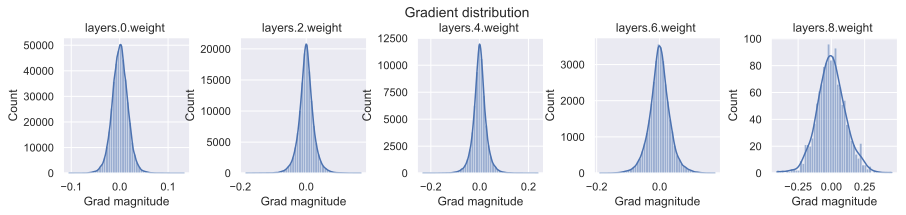

layers.0.weight - Variance: 0.0002715133305173367
layers.2.weight - Variance: 0.0005363161326386034
layers.4.weight - Variance: 0.000756742199882865
layers.6.weight - Variance: 0.0011158478446304798
layers.8.weight - Variance: 0.01197680551558733


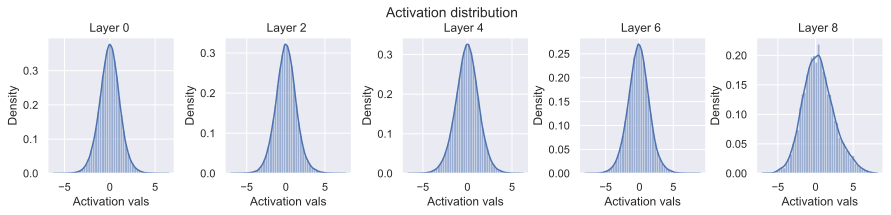

Layer 0 - Variance: 1.2782073020935059
Layer 2 - Variance: 1.7964832782745361
Layer 4 - Variance: 1.696260929107666
Layer 6 - Variance: 2.545058012008667
Layer 8 - Variance: 4.307927131652832


In [18]:
def xavier_init(model):
    for name, param in model.named_parameters():
        if name.endswith('.bias'):
            param.data.fill_(0)
        else:
            bound = math.sqrt(6) / math.sqrt(param.shape[0] + param.shape[1])
            param.data.uniform_(-bound, bound)


xavier_init(model)
visualize_gradients(model, print_variance=True)
visualize_activations(model, print_variance=True)

We see that the `Xavier Initialization` balances the `variances` and `activation`. NOTE, a significant higher `variance` for the output layer is due to the large `difference` of `input` and `output` dimensions. But, currently we assume our `activation` to be linear.

So, if we use a `non-linear` activation like `TanH`, a common assumption would be that for small values during the initial steps in training, `TanH` works as a linear function such that we don't have to adjust our calculation.

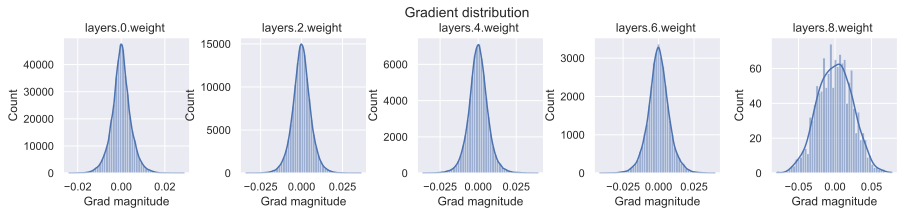

layers.0.weight - Variance: 2.0070079699507914e-05
layers.2.weight - Variance: 3.243146784370765e-05
layers.4.weight - Variance: 4.1898842027876526e-05
layers.6.weight - Variance: 5.652980325976387e-05
layers.8.weight - Variance: 0.0005544372834265232


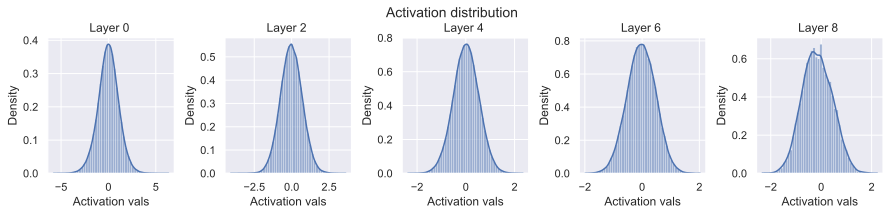

Layer 0 - Variance: 1.197150707244873
Layer 2 - Variance: 0.5269485712051392
Layer 4 - Variance: 0.27602332830429077
Layer 6 - Variance: 0.24722661077976227
Layer 8 - Variance: 0.3518862724304199


In [19]:
model = BaseNetwork(act_fn=nn.Tanh()).to(device)
xavier_init(model)

visualize_gradients(model, print_variance=True)
visualize_activations(model, print_variance=True)

Although, the `variance` decreases over depth, it is apparent that the activation distrbution becomes more focused on the low values. Therefore, our `variance` will stablize around `0.25`. So, it concludes that `Xavier Initialization` works well for `TanH` networks. 

In case of `ReLU`, we cannot assume that non-linear becomes linear for `small values`. The `ReLU` sets half of the inputs to 0 so that also the expectation of the input is not `0`. However, as long as the expectation of `W` is 0 and `b = 0`, the expectation of the output is `0`. The part where the calculation of the `ReLU` initialization differs from the identity is when determining <img src="https://pytorch-lightning.readthedocs.io/en/latest/_images/math/ddc90fca2320bd6c61229410d323a8352c4b90d5.png"/>

<img src="https://pytorch-lightning.readthedocs.io/en/latest/_images/math/cad8ceb41f952114ec8304403e7ebc9e4caee17c.png"/>

If we assume now that x is the output of a ReLU activation (from a previous layer, `x = max(0, y~)`), we can calculate the expectation as follows
<img src="https://pytorch-lightning.readthedocs.io/en/latest/_images/math/69d6adf0f566822c85a3a1d0859bbea78c519137.png"/>

Thus, we have an additional factor of `1/2` in eq, so that the `desired weight variance` becomes `2/dx`. This gives `Kaiming Initialization`. Note that the Kaiming initialization does not use the `harmonic mean` between input and output size. They argue that using `d_x` or `d_y` both lead to stable gradients throughout the network, and only depend on the overall input and output size of the network. Hence can only use `dx`.

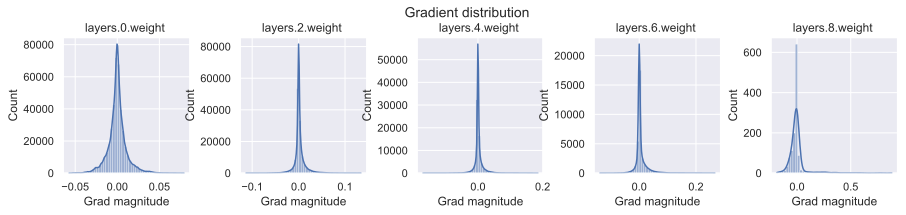

layers.0.weight - Variance: 0.00012432514631655067
layers.2.weight - Variance: 0.00014867488062009215
layers.4.weight - Variance: 0.00018409351469017565
layers.6.weight - Variance: 0.00042226651567034423
layers.8.weight - Variance: 0.008767856284976006


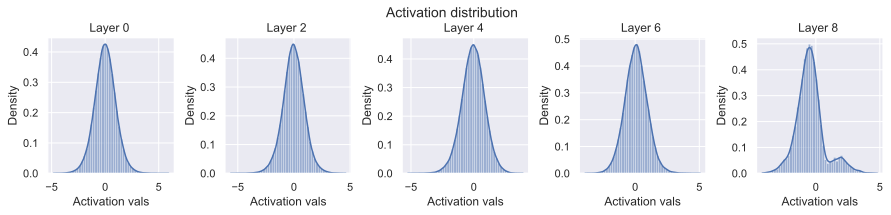

Layer 0 - Variance: 0.9829571843147278
Layer 2 - Variance: 0.9188953042030334
Layer 4 - Variance: 0.8493317365646362
Layer 6 - Variance: 0.7726171612739563
Layer 8 - Variance: 1.2534748315811157


In [20]:
def kaiming_init(model):
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            param.data.fill_(0)
        elif name.startswith("layers.0"):  # The first layer does not have ReLU applied on its input
            param.data.normal_(0, 1 / math.sqrt(param.shape[1]))
        else:
            param.data.normal_(0, math.sqrt(2) / math.sqrt(param.shape[1]))
    

model = BaseNetwork(act_fn=nn.ReLU()).to(device)
kaiming_init(model)

visualize_gradients(model, print_variance=True)
visualize_activations(model, print_variance=True)